### Inference Model Denoising & Classification


In [1]:
# check versi Tensorflow & Keras
import tensorflow as tf
import keras 

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.12.0
2.2.4


In [2]:
import os
import numpy as np
import pandas as pd
import datetime

from keras import models
from keras import backend as K
from tensorflow.keras.models import load_model as tf_kr_models

In [3]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [4]:
import neurokit2 as nk

In [5]:
import warnings
warnings.filterwarnings('ignore')

# load model

In [6]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [7]:
denoising_model_name = 'denoising_conv_AE.h5'
denoising_Conv_AE_model = tf_kr_models(denoising_model_name, custom_objects={'rmse': rmse})
print("[INFO] Load denoising model %s..." % denoising_model_name)

[INFO] Load denoising model denoising_conv_AE.h5...


In [8]:
feature_labels = {
    "rr_interval" : "RR Interval",
    "qt_interval" : "QT Interval",
    "qrs_complex" : "QRS Complex",
    "rr_interval,qt_interval" : "RR Interval & QT Interval",
    "rr_interval,qrs_complex" : "RR Interval & QRS Complex",
    "qt_interval,qrs_complex" : "QT Interval & QRS Complex",
    "rr_interval,qt_interval,qrs_complex" : "RR Interval, QT Interval & QRS Complex"
}

In [9]:
classification_models = {}
for label in feature_labels :
    filename = "%s_model.h5" % label
    if not filename:
        raise Exception('\[ERROR] Cant find %s models!.' % (filename))

    print("[INFO] Load classification model %s..." % filename)
    classification_models[label] = tf_kr_models(filename)

[INFO] Load classification model rr_interval_model.h5...
[INFO] Load classification model qt_interval_model.h5...
[INFO] Load classification model qrs_complex_model.h5...
[INFO] Load classification model rr_interval,qt_interval_model.h5...
[INFO] Load classification model rr_interval,qrs_complex_model.h5...
[INFO] Load classification model qt_interval,qrs_complex_model.h5...
[INFO] Load classification model rr_interval,qt_interval,qrs_complex_model.h5...


In [10]:
label_names = ['AF', 'N']

fs = 250
sample_size = 6 # 6s

In [22]:
dataset_folder ="dataset/"
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("AFDB_pasien") > -1 and filename.find("inference") == -1:
        filenames.append(filename)

In [23]:
filenames

['AFDB_pasien_AF 1.csv',
 'AFDB_pasien_AF 2.csv',
 'AFDB_pasien_AF 3.csv',
 'AFDB_pasien_AF 4.csv',
 'AFDB_pasien_AF 5.csv',
 'AFDB_pasien_AF 6.csv',
 'AFDB_pasien_AF 7.csv',
 'AFDB_pasien_Normal 1.csv',
 'AFDB_pasien_Normal 2.csv',
 'AFDB_pasien_Normal 3.csv',
 'AFDB_pasien_Normal 4.csv']

# load inference data

In [24]:
# scale data from 0 to 1
def scaler(X):
    res = []
    for x in X :
        global_min = x.min()
        x = np.reshape(x, (2, fs*sample_size))
        for i in range(len(x)):
            idx = np.max(np.nonzero(x[i]))
            x[i][idx+1:] = global_min
        x = np.reshape(x, (fs*sample_size*2))
        res.append((x - x.min())/(x.max() - x.min()))
    return np.array(res)

In [25]:
inference_data = {}
for name in filenames:
    infer = pd.read_csv(dataset_folder + name, header=None)
    inference_data[name] = infer

In [26]:
inference_data[filenames[0]].head()

0         1         2         3         4         5         6     \
0 -0.011796 -0.012682 -0.012654 -0.011895 -0.010711 -0.009445 -0.008409   
1  0.017126  0.018861  0.019327  0.018697  0.017347  0.015747  0.014269   
2  0.010385  0.010956  0.010606  0.009504  0.007949  0.006286  0.004811   
3  0.030356  0.034980  0.038140  0.040075  0.041277  0.042323  0.043599   
4  0.134341  0.187600  0.256447  0.343399  0.448379  0.567496  0.692610   

       7         8         9     ...      2990      2991     2992     2993  \
0 -0.007725 -0.007376 -0.007229  ...  0.000000  0.000000  0.00000  0.00000   
1  0.013288  0.012986  0.013381  ...  0.231341  0.229416  0.22707  0.22471   
2  0.003699  0.002976  0.002534  ...  0.000000  0.000000  0.00000  0.00000   
3  0.045454  0.047956  0.050978  ...  0.000000  0.000000  0.00000  0.00000   
4  0.811857  0.911385  0.977769  ...  0.000000  0.000000  0.00000  0.00000   

       2994      2995      2996      2997      2998      2999  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.222711  0.221272  0.220223  0.219363  0.218054  0.215549  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[5 rows x 3000 columns]

In [27]:
mat_infer_data = {}
for name in filenames:
    infer_df = inference_data[name]
    X = infer_df.values
    X = scaler(X)
    mat_infer_data[name] = X
    

# Apply denoising model to inference data

In [28]:
Conv_AE_den_res = {}
for name in filenames:
    Conv_AE_den_res[name] = denoising_Conv_AE_model.predict(mat_infer_data[name].reshape(len(mat_infer_data[name]), fs*sample_size*2, 1))
    print("denoising data - %s" % name)

denoising data - AFDB_pasien_AF 1.csv
denoising data - AFDB_pasien_AF 2.csv
denoising data - AFDB_pasien_AF 3.csv
denoising data - AFDB_pasien_AF 4.csv
denoising data - AFDB_pasien_AF 5.csv
denoising data - AFDB_pasien_AF 6.csv
denoising data - AFDB_pasien_AF 7.csv
denoising data - AFDB_pasien_Normal 1.csv
denoising data - AFDB_pasien_Normal 2.csv
denoising data - AFDB_pasien_Normal 3.csv
denoising data - AFDB_pasien_Normal 4.csv


In [29]:
def plot_decoded_signal(decoded_signal, original_signal, name, y_label="Normalized Value"):
    time = np.arange(len(decoded_signal[0])) / fs
    
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.plot(time, decoded_signal[0])
    plt.plot(time, decoded_signal[1])
    plt.title("Denoised Signal - " + name)
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(time, original_signal[0])
    plt.plot(time, original_signal[1])
    plt.title("Original Signal")
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.tight_layout()
    plt.show()

- Check result

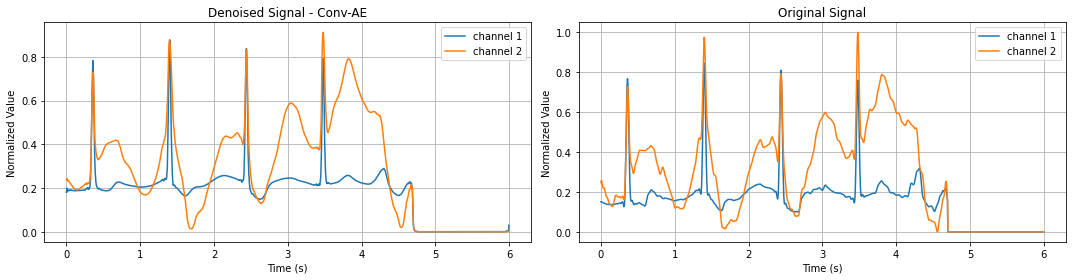

In [56]:
name = filenames[0]
idx = 2

y = Conv_AE_den_res[name][idx]
x = mat_infer_data[name][idx]

signal = np.reshape(x, (2, fs*sample_size))
decoded_signal = np.reshape(y, (2, fs*sample_size))

plot_decoded_signal(decoded_signal, signal, name="Conv-AE")

# Feature Extraction
- RR Interval
- QT Interval
- QRS Complex

In [31]:
# Transform data for Feature Extration

mat_infer_data_transform = {}

for name in filenames:
    print("[INFO] Transforming sample %s..." % name)
    signal = []
    for item in mat_infer_data[name] :
        signal.append(item.reshape(2, fs*sample_size, -1))
        
    mat_infer_data_transform[name] = signal

[INFO] Transforming sample AFDB_pasien_AF 1.csv...
[INFO] Transforming sample AFDB_pasien_AF 2.csv...
[INFO] Transforming sample AFDB_pasien_AF 3.csv...
[INFO] Transforming sample AFDB_pasien_AF 4.csv...
[INFO] Transforming sample AFDB_pasien_AF 5.csv...
[INFO] Transforming sample AFDB_pasien_AF 6.csv...
[INFO] Transforming sample AFDB_pasien_AF 7.csv...
[INFO] Transforming sample AFDB_pasien_Normal 1.csv...
[INFO] Transforming sample AFDB_pasien_Normal 2.csv...
[INFO] Transforming sample AFDB_pasien_Normal 3.csv...
[INFO] Transforming sample AFDB_pasien_Normal 4.csv...


## RR Interval

In [57]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    r_peaks_n = [r / fs for r in r_peaks]
    plt.vlines(r_peaks_n, ymin, ymax,
               color="r",
               linewidth=2)
    

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.show()

[INFO] check R Peak for sample AFDB_pasien_AF 1.csv


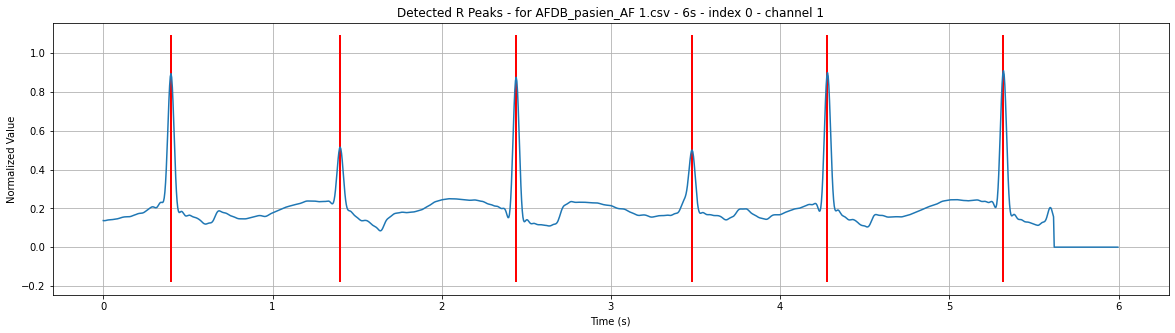

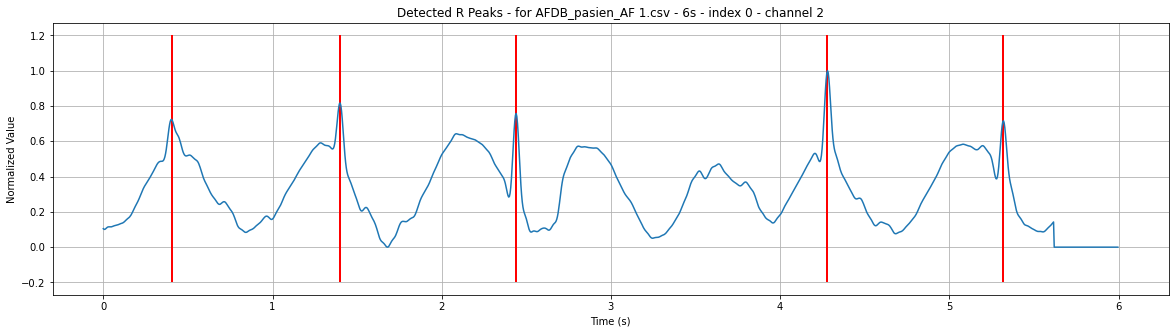

In [58]:
name = filenames[0]
print("[INFO] check R Peak for sample %s" % name)
test_signal = mat_infer_data_transform[name]
idx = 0
ecg_signal = np.array(test_signal[idx])

for ch in range(0,2):
    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
    plot_r_peaks(r_peaks['ECG_R_Peaks'], 
                 ecg_signal[ch], 
                 fs, 
                 label="Detected R Peaks - for %s - %ds - index %d - channel %d" % 
                         (name,
                          sample_size, 
                          idx, 
                          ch + 1))

In [59]:
pad_size = 15 # set 15 if using 6s, set 50 if using 16s

rr_interval_data = {}

for name in filenames :
    print("[INFO] find R-R Interval for sample %s..." % name)
    RR_Interval = []
    for i in range(len(test_signal)) :
        ecg_signal = np.array(test_signal[i])
        if len(ecg_signal) > 0:
            r_peaks = []
            try :
                signal_ch = []
                for ch in [0, 1]:
                    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
                    if len(r_peaks['ECG_R_Peaks']) < 2 :
                        raise "R Peaks not found"

                    rr_intv = np.diff(r_peaks['ECG_R_Peaks'])
                    if len(rr_intv) > pad_size :
                        print("[INFO] number of peak more than %d : %d" % (pad_size, len(rr_intv)))
                    n = len(rr_intv) if len(rr_intv) <= pad_size else pad_size

                    pad = np.zeros(pad_size)
                    pad[0:n] = rr_intv[0:n]
                    signal_ch.append(pad)
                RR_Interval.append(signal_ch)
            except Exception as e:
                print("[ERROR] processing data in idx %d  : %s" % (i, e))
    rr_interval_data[name] = RR_Interval

[INFO] find R-R Interval for sample AFDB_pasien_AF 1.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 2.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 3.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 4.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 5.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 6.csv...
[INFO] find R-R Interval for sample AFDB_pasien_AF 7.csv...
[INFO] find R-R Interval for sample AFDB_pasien_Normal 1.csv...
[INFO] find R-R Interval for sample AFDB_pasien_Normal 2.csv...
[INFO] find R-R Interval for sample AFDB_pasien_Normal 3.csv...
[INFO] find R-R Interval for sample AFDB_pasien_Normal 4.csv...


In [35]:
# convert rr interval list to dataframe
rr_interval_df = {}
for name in filenames :
    RR_Interval = rr_interval_data[name]
    data_test = []
    for i in range(len(RR_Interval)):
        x = list(RR_Interval[i][0])
        x.extend(list(RR_Interval[i][1]))
        data_test.append(x)
    rr_interval_df[name] = pd.DataFrame(data_test)

In [36]:
# check rr interval dataframe
name = filenames[0]
rr_interval_df[name].head()

0      1      2      3      4    5    6    7    8    9   ...     20  \
0  250.0  260.0  260.0  200.0  260.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1  260.0  200.0  260.0  260.0  251.0  0.0  0.0  0.0  0.0  0.0  ...  250.0   
2  260.0  260.0  260.0  209.0   89.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3  260.0  260.0  178.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4  250.0  260.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

    21   22   23   24   25   26   27   28   29  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 30 columns]

## QRS Complex

In [37]:
def plot_QRS_complex(r_onsets, r_offsets, data, fs, label = "Detected QRS Complex"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_onsets], ymin, ymax,
               color="y",
               linewidth=2,
               label="R Onsets")
    plt.vlines([r / fs for r in r_offsets], ymin, ymax,
               color="g",
               linewidth=2,
               label="R Offsets")
    
    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.show()

[INFO] check QRS Complex for sample AFDB_pasien_AF 1.csv


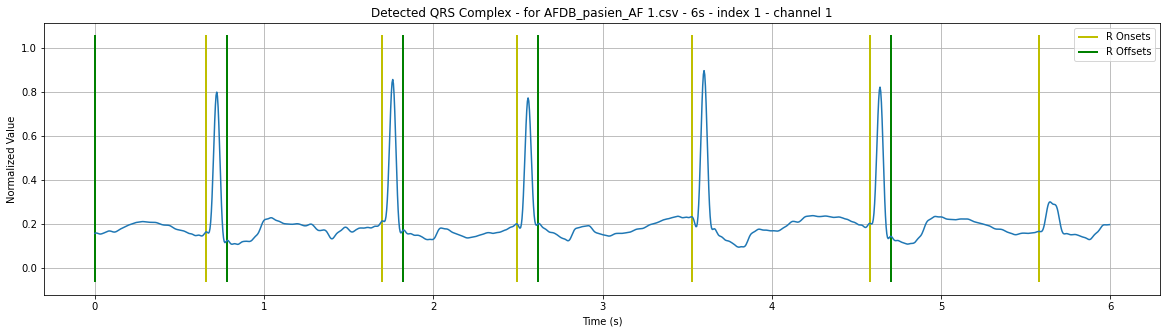

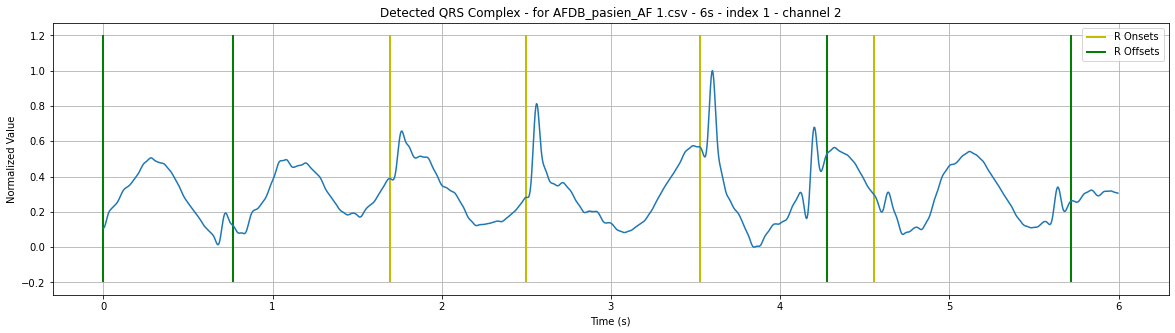

In [38]:
name = filenames[0]
print("[INFO] check QRS Complex for sample %s" % name)
test_signal = mat_infer_data_transform[name]
idx = 1
ecg_signal = np.array(test_signal[idx])

for ch in range(0,2):
    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
    _, waves_peak = nk.ecg_delineate(ecg_signal[ch, :, 0], r_peaks, sampling_rate=fs, method="dwt")
    r_onsets = np.nan_to_num(waves_peak['ECG_R_Onsets'])
    r_offsets = np.nan_to_num(waves_peak['ECG_R_Offsets'])
    plot_QRS_complex(r_onsets, 
                     r_offsets, 
                     ecg_signal[ch, :, 0],
                     fs, 
                     label="Detected QRS Complex - for %s - %ds - index %d - channel %d" % 
                             (name,
                              sample_size, 
                              idx, 
                              ch + 1))

In [39]:
pad_size = 15 # set 15 if using 6s, set 50 if using 16s

qrs_complex_data = {}

for name in filenames :
    print("[INFO] find QRS Complex for sample %s..." % name)
    
    QRS_Complex = []
    for i in range(len(test_signal)) :
        ecg_signal = np.array(test_signal[i])
        if len(ecg_signal) > 0:
            r_peaks = []
            try :
                signal_ch = []
                for ch in [0, 1]:
                    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
                    if len(r_peaks['ECG_R_Peaks']) < 2 :
                        raise "R Peaks not found"

                    _, waves_peak = nk.ecg_delineate(ecg_signal[ch, :, 0], r_peaks, sampling_rate=fs, method="dwt")
                    r_onsets = waves_peak['ECG_R_Onsets']
                    r_offsets = waves_peak['ECG_R_Offsets']

                    qrs_complex =  np.nan_to_num(np.diff(np.array([r_onsets, r_offsets]).T))[:, 0]

                    n = len(qrs_complex) if len(qrs_complex) <= pad_size else pad_size
                    pad = np.zeros(pad_size)
                    pad[0:n] = qrs_complex[0:n]  
                    signal_ch.append(pad)
                QRS_Complex.append(signal_ch)
            except Exception as e:
                print("[ERROR] processing data in idx %d  : %s" % (i, e))
    qrs_complex_data[name] = QRS_Complex

[INFO] find QRS Complex for sample AFDB_pasien_AF 1.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 2.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 3.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 4.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 5.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 6.csv...
[INFO] find QRS Complex for sample AFDB_pasien_AF 7.csv...
[INFO] find QRS Complex for sample AFDB_pasien_Normal 1.csv...
[INFO] find QRS Complex for sample AFDB_pasien_Normal 2.csv...
[INFO] find QRS Complex for sample AFDB_pasien_Normal 3.csv...
[INFO] find QRS Complex for sample AFDB_pasien_Normal 4.csv...


In [40]:
# convert qrs_complex list to dataframe
qrs_complex_df = {}
for name in filenames :
    QRS_Complex = qrs_complex_data[name]
    data_test = []
    for i in range(len(QRS_Complex)):
        x = list(QRS_Complex[i][0])
        x.extend(list(QRS_Complex[i][1]))
        data_test.append(x)
    qrs_complex_df[name] = pd.DataFrame(data_test)

In [41]:
# check qrs complex dataframe
name = filenames[0]
rr_interval_df[name].head()

0      1      2      3      4    5    6    7    8    9   ...     20  \
0  250.0  260.0  260.0  200.0  260.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1  260.0  200.0  260.0  260.0  251.0  0.0  0.0  0.0  0.0  0.0  ...  250.0   
2  260.0  260.0  260.0  209.0   89.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3  260.0  260.0  178.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4  250.0  260.0    0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

    21   22   23   24   25   26   27   28   29  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 30 columns]

## QT Interval

In [42]:
def plot_QT_Interval(r_onsets, t_offsets, data, fs, label = "Detected QT Interval"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_onsets], ymin, ymax,
               color="y",
               linewidth=2,
               label="R Onsets")
    plt.vlines([r / fs for r in t_offsets], ymin, ymax,
               color="g",
               linewidth=2,
               label="T Offsets")

    plt.title(label)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.show()

[INFO] check QT Interval for sample AFDB_pasien_AF 1.csv


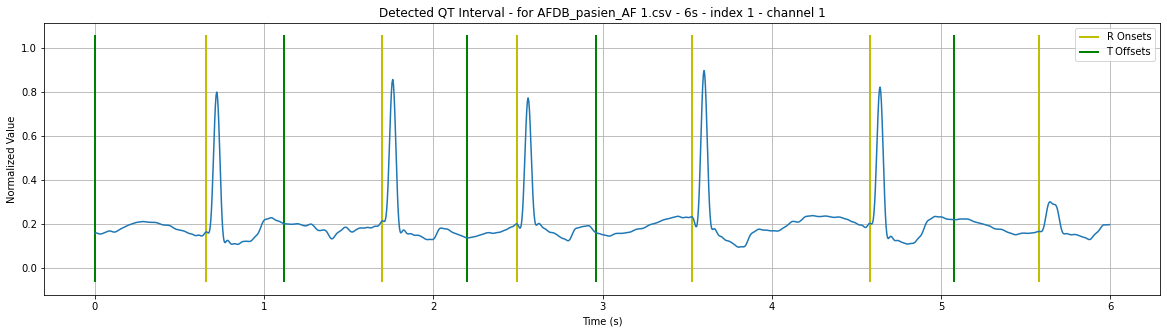

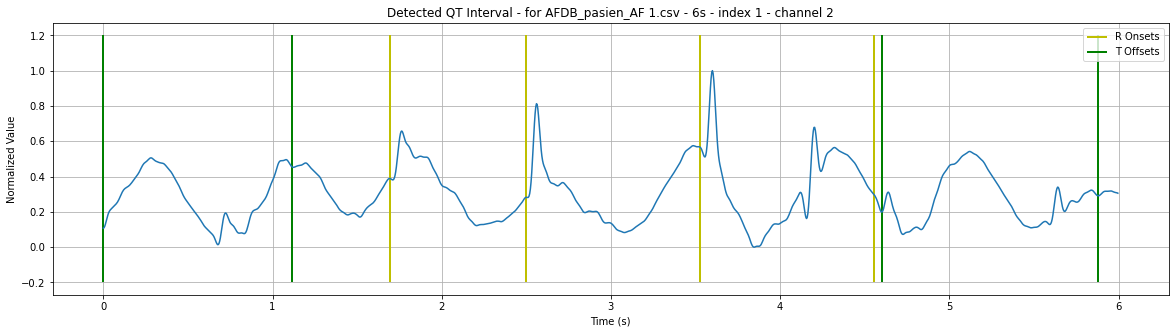

In [43]:
name = filenames[0]
print("[INFO] check QT Interval for sample %s" % name)
test_signal = mat_infer_data_transform[name]
idx = 1
ecg_signal = np.array(test_signal[idx])

for ch in range(0,2):
    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
    _, waves_peak = nk.ecg_delineate(ecg_signal[ch, :, 0], r_peaks, sampling_rate=fs, method="dwt")
    r_onsets = np.nan_to_num(waves_peak['ECG_R_Onsets'])
    t_offsets = np.nan_to_num(waves_peak['ECG_T_Offsets'])
    plot_QT_Interval(r_onsets, 
                     t_offsets, 
                     ecg_signal[ch, :, 0],
                     fs, 
                     label="Detected QT Interval - for %s - %ds - index %d - channel %d" % 
                             (name,
                              sample_size, 
                              idx, 
                              ch + 1))

In [44]:
pad_size = 15 # set 15 if using 6s, set 50 if using 16s

qt_interval_data = {}

for name in filenames :
    print("[INFO] find QT Interval for sample %s..." % name)
    
    QT_Interval = []
    for i in range(len(test_signal)) :
        ecg_signal = np.array(test_signal[i])
        if len(ecg_signal) > 0:
            r_peaks = []
            try :
                signal_ch = []
                for ch in [0, 1]:
                    _, r_peaks = nk.ecg_peaks(ecg_signal[ch, :, 0], sampling_rate=fs)
                    if len(r_peaks['ECG_R_Peaks']) < 2 :
                        raise "R Peaks not found"

                    _, waves_peak = nk.ecg_delineate(ecg_signal[ch, :, 0], r_peaks, sampling_rate=fs, method="dwt")
                    r_onsets = waves_peak['ECG_R_Onsets']
                    t_offsets = waves_peak['ECG_T_Offsets']

                    qt_interval =  np.nan_to_num(np.diff(np.array([r_onsets, t_offsets]).T))[:, 0]

                    n = len(qt_interval) if len(qt_interval) <= pad_size else pad_size
                    pad = np.zeros(pad_size)
                    pad[0:n] = qt_interval[0:n]  
                    signal_ch.append(pad)
                QT_Interval.append(signal_ch)
            except Exception as e:
                print("[ERROR] processing data in idx %d  : %s" % (i, e))
    qt_interval_data[name] = QT_Interval

[INFO] find QT Interval for sample AFDB_pasien_AF 1.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 2.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 3.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 4.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 5.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 6.csv...
[INFO] find QT Interval for sample AFDB_pasien_AF 7.csv...
[INFO] find QT Interval for sample AFDB_pasien_Normal 1.csv...
[INFO] find QT Interval for sample AFDB_pasien_Normal 2.csv...
[INFO] find QT Interval for sample AFDB_pasien_Normal 3.csv...
[INFO] find QT Interval for sample AFDB_pasien_Normal 4.csv...


In [45]:
# convert qt interval list to dataframe
qt_interval_df = {}
for name in filenames :
    QT_Interval = qt_interval_data[name]
    data_test = []
    for i in range(len(QT_Interval)):
        x = list(QT_Interval[i][0])
        x.extend(list(QT_Interval[i][1]))
        data_test.append(x)
    qt_interval_df[name] = pd.DataFrame(data_test)

In [46]:
# check qt interval dataframe
name = filenames[0]
qt_interval_df[name].head()

0      1      2      3      4     5    6    7    8    9   ...   20   21  \
0    0.0    0.0    0.0  126.0    0.0  95.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  116.0  126.0  118.0    0.0  124.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2    0.0    0.0    0.0  129.0  105.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3  117.0  138.0  118.0    0.0    0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4   65.0    0.0    0.0    0.0    0.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    22   23   24   25   26   27   28   29  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 30 columns]

# Apply to CNN model

In [47]:

classification_result = {}
for name in filenames:
    print("\n\n\n[INFO] processing sample %s..." % (name))
    classification_result[name] = {}
    for label in feature_labels :
        print("\n[INFO] read feature data %s at sample %s..." % (label, name))
        processed_dfs = []

        selected_feature_len = len(label.split(sep=","))
        for i, feature in enumerate(label.split(sep=",")):
            if feature == "rr_interval" :
                processed_dfs.append(rr_interval_df[name])
            if feature == "qt_interval" :
                processed_dfs.append(qt_interval_df[name])
            if feature == "qrs_complex" :
                processed_dfs.append(qrs_complex_df[name])

        processed_df = pd.concat(processed_dfs, axis=0, ignore_index=True)
        X = processed_df.values[:, :pad_size*2*selected_feature_len].reshape(-1, pad_size*2*selected_feature_len, 1)
        print("[INFO] sample dimension :", X.shape)
        
        # predict by classif model
        classification_result[name][label] = classification_models[label].predict(X)

        print("predicting data - %s for feature %s" % (name, label))




[INFO] processing sample AFDB_pasien_AF 1.csv...

[INFO] read feature data rr_interval at sample AFDB_pasien_AF 1.csv...
[INFO] sample dimension : (23, 30, 1)
predicting data - AFDB_pasien_AF 1.csv for feature rr_interval

[INFO] read feature data qt_interval at sample AFDB_pasien_AF 1.csv...
[INFO] sample dimension : (23, 30, 1)
predicting data - AFDB_pasien_AF 1.csv for feature qt_interval

[INFO] read feature data qrs_complex at sample AFDB_pasien_AF 1.csv...
[INFO] sample dimension : (23, 30, 1)
predicting data - AFDB_pasien_AF 1.csv for feature qrs_complex

[INFO] read feature data rr_interval,qt_interval at sample AFDB_pasien_AF 1.csv...
[INFO] sample dimension : (23, 60, 1)
predicting data - AFDB_pasien_AF 1.csv for feature rr_interval,qt_interval

[INFO] read feature data rr_interval,qrs_complex at sample AFDB_pasien_AF 1.csv...
[INFO] sample dimension : (23, 60, 1)
predicting data - AFDB_pasien_AF 1.csv for feature rr_interval,qrs_complex

[INFO] read feature data qt_interv

- Check result

In [48]:
def plot_cnn_result(data, label='Deep-AE', confidence=0.0):
    confidence = confidence*100
    # show results
    data = data.reshape(2,300)
    time = np.arange(len(data[0])) / fs
    
    plt.figure(figsize=(6,4))
    plt.title("Classification Result : %s - confidence (%.2f%%)" % (label, confidence))
    plt.xlabel("samples - n")
    plt.plot(time, data[0],"g", label="channel 1")
    plt.plot(time, data[1],"r", label="channel 2")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.show()

# Finalize result

In [49]:
prediction_final_result = {}
for name in filenames :
    print("\n\n\n[INFO] show result for sample %s..." % (name))
    prediction_final_result[name] = {}
    for label in feature_labels :
        print("\n[INFO] checking classification result for sample %s and feature %s" % (name, label))
        cnn_res = classification_result[name][label]
        
        pred_result = []
        for i, res in enumerate(cnn_res):
            predicted_id = np.argmax(res)
            pred_label = label_names[predicted_id]
            confidence = res[predicted_id]
            
            pred_label = pred_label if confidence > 0.50 else '?' # threshold for confidence level , set to 50%
            pred_result.append([name, i, pred_label, confidence])
            print('%s \t index - %d \t %s \t %.2f %%' % (name, i, pred_label, confidence*100))
            
        prediction_final_result[name][label] = pred_result
        




[INFO] show result for sample AFDB_pasien_AF 1.csv...

[INFO] checking classification result for sample AFDB_pasien_AF 1.csv and feature rr_interval
AFDB_pasien_AF 1.csv 	 index - 0 	 AF 	 91.78 %
AFDB_pasien_AF 1.csv 	 index - 1 	 AF 	 73.34 %
AFDB_pasien_AF 1.csv 	 index - 2 	 AF 	 94.55 %
AFDB_pasien_AF 1.csv 	 index - 3 	 AF 	 67.73 %
AFDB_pasien_AF 1.csv 	 index - 4 	 N 	 86.66 %
AFDB_pasien_AF 1.csv 	 index - 5 	 N 	 90.81 %
AFDB_pasien_AF 1.csv 	 index - 6 	 N 	 72.41 %
AFDB_pasien_AF 1.csv 	 index - 7 	 AF 	 65.32 %
AFDB_pasien_AF 1.csv 	 index - 8 	 AF 	 88.60 %
AFDB_pasien_AF 1.csv 	 index - 9 	 AF 	 99.05 %
AFDB_pasien_AF 1.csv 	 index - 10 	 AF 	 91.34 %
AFDB_pasien_AF 1.csv 	 index - 11 	 N 	 96.25 %
AFDB_pasien_AF 1.csv 	 index - 12 	 AF 	 65.83 %
AFDB_pasien_AF 1.csv 	 index - 13 	 AF 	 70.69 %
AFDB_pasien_AF 1.csv 	 index - 14 	 AF 	 98.99 %
AFDB_pasien_AF 1.csv 	 index - 15 	 N 	 85.03 %
AFDB_pasien_AF 1.csv 	 index - 16 	 AF 	 99.13 %
AFDB_pasien_AF 1.csv 	 index -

In [50]:
prediction_final_result_df = {}
for name in filenames :
    prediction_final_result_df[name] = {}
    for label in feature_labels :
        pred_result = prediction_final_result[name][label]
        prediction_final_result_df[name][label] = pd.DataFrame(pred_result, columns=['filename', 'idx', 'label', 'confidence'])

In [51]:
name = filenames[0]
label = "rr_interval"
prediction_final_result_df[name][label].head() 

filename  idx label  confidence
0  AFDB_pasien_AF 1.csv    0    AF    0.917811
1  AFDB_pasien_AF 1.csv    1    AF    0.733405
2  AFDB_pasien_AF 1.csv    2    AF    0.945489
3  AFDB_pasien_AF 1.csv    3    AF    0.677340
4  AFDB_pasien_AF 1.csv    4     N    0.866633

In [52]:
for name in filenames:
    print("\n\n\n[INFO] Summary for sample : ", name)
    for label in feature_labels :
        print("\n[INFO] Feature : ", label)
        pred_result_df = prediction_final_result_df[name][label]
        count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
        for key in count :
            print("%s \t: %d" % (key, count[key]))




[INFO] Summary for sample :  AFDB_pasien_AF 1.csv

[INFO] Feature :  rr_interval
AF 	: 16
N 	: 7

[INFO] Feature :  qt_interval
AF 	: 21
N 	: 2

[INFO] Feature :  qrs_complex
AF 	: 19
N 	: 4

[INFO] Feature :  rr_interval,qt_interval
AF 	: 19
N 	: 4

[INFO] Feature :  rr_interval,qrs_complex
AF 	: 21
N 	: 2

[INFO] Feature :  qt_interval,qrs_complex
AF 	: 22
N 	: 1

[INFO] Feature :  rr_interval,qt_interval,qrs_complex
AF 	: 23



[INFO] Summary for sample :  AFDB_pasien_AF 2.csv

[INFO] Feature :  rr_interval
AF 	: 16
N 	: 7

[INFO] Feature :  qt_interval
AF 	: 21
N 	: 2

[INFO] Feature :  qrs_complex
AF 	: 19
N 	: 4

[INFO] Feature :  rr_interval,qt_interval
AF 	: 19
N 	: 4

[INFO] Feature :  rr_interval,qrs_complex
AF 	: 21
N 	: 2

[INFO] Feature :  qt_interval,qrs_complex
AF 	: 22
N 	: 1

[INFO] Feature :  rr_interval,qt_interval,qrs_complex
AF 	: 23



[INFO] Summary for sample :  AFDB_pasien_AF 3.csv

[INFO] Feature :  rr_interval
AF 	: 16
N 	: 7

[INFO] Feature :  qt_interval

In [53]:
def plot_donat(porsion, title, labels, colors=['red', 'green', 'blue']):
    plt.figure(figsize=(10,5))

    circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(porsion, 
            labels=labels, 
            colors=colors,
            autopct='%1.1f%%')

    plt.title(title)
    p = plt.gcf()
    p.gca().add_artist(circle)
    plt.show()




[INFO] Plot for sample :  AFDB_pasien_AF 1.csv

[INFO] Feature (AFDB_pasien_AF 1.csv) :  rr_interval


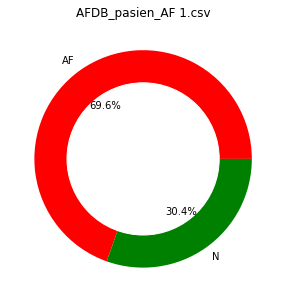


[INFO] Feature (AFDB_pasien_AF 1.csv) :  qt_interval


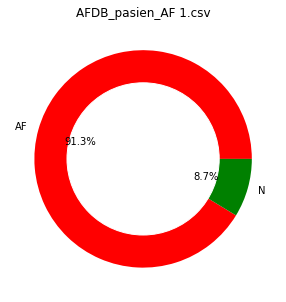


[INFO] Feature (AFDB_pasien_AF 1.csv) :  qrs_complex


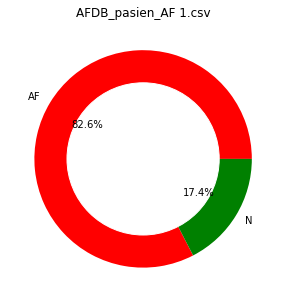


[INFO] Feature (AFDB_pasien_AF 1.csv) :  rr_interval,qt_interval


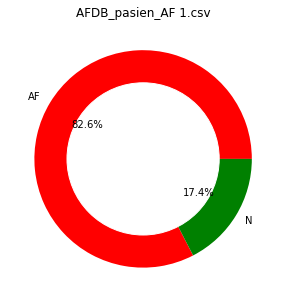


[INFO] Feature (AFDB_pasien_AF 1.csv) :  rr_interval,qrs_complex


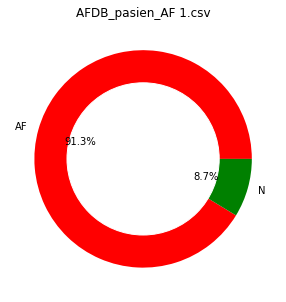


[INFO] Feature (AFDB_pasien_AF 1.csv) :  qt_interval,qrs_complex


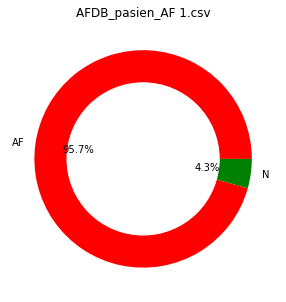


[INFO] Feature (AFDB_pasien_AF 1.csv) :  rr_interval,qt_interval,qrs_complex


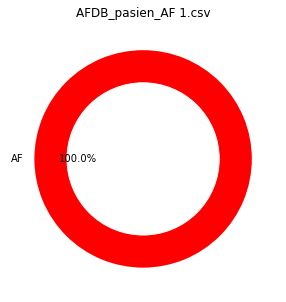




[INFO] Plot for sample :  AFDB_pasien_AF 2.csv

[INFO] Feature (AFDB_pasien_AF 2.csv) :  rr_interval


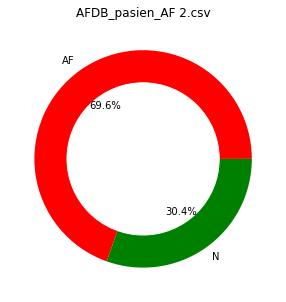


[INFO] Feature (AFDB_pasien_AF 2.csv) :  qt_interval


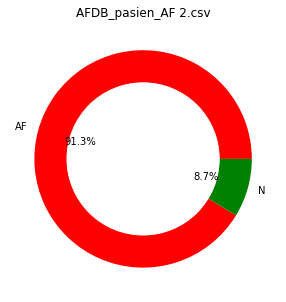


[INFO] Feature (AFDB_pasien_AF 2.csv) :  qrs_complex


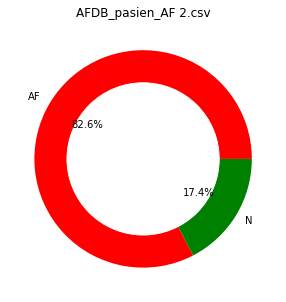


[INFO] Feature (AFDB_pasien_AF 2.csv) :  rr_interval,qt_interval


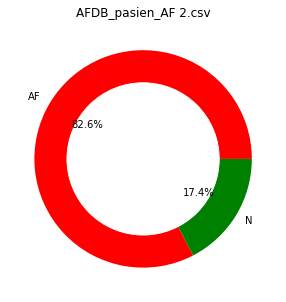


[INFO] Feature (AFDB_pasien_AF 2.csv) :  rr_interval,qrs_complex


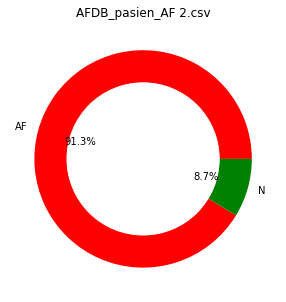


[INFO] Feature (AFDB_pasien_AF 2.csv) :  qt_interval,qrs_complex


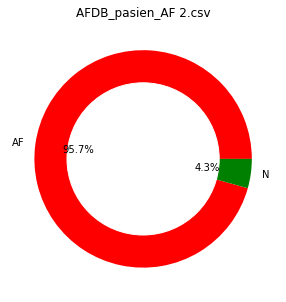


[INFO] Feature (AFDB_pasien_AF 2.csv) :  rr_interval,qt_interval,qrs_complex


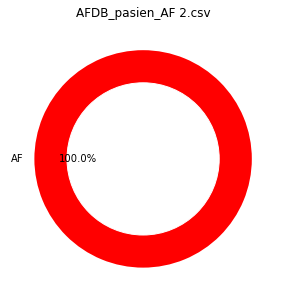




[INFO] Plot for sample :  AFDB_pasien_AF 3.csv

[INFO] Feature (AFDB_pasien_AF 3.csv) :  rr_interval


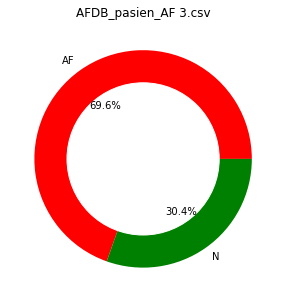


[INFO] Feature (AFDB_pasien_AF 3.csv) :  qt_interval


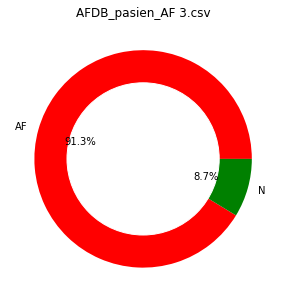


[INFO] Feature (AFDB_pasien_AF 3.csv) :  qrs_complex


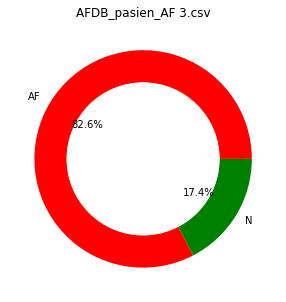


[INFO] Feature (AFDB_pasien_AF 3.csv) :  rr_interval,qt_interval


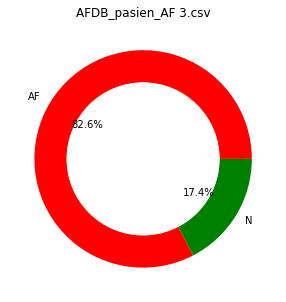


[INFO] Feature (AFDB_pasien_AF 3.csv) :  rr_interval,qrs_complex


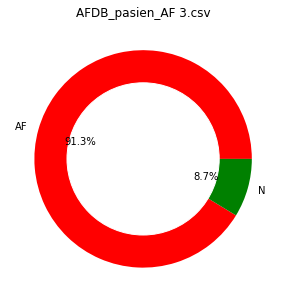


[INFO] Feature (AFDB_pasien_AF 3.csv) :  qt_interval,qrs_complex


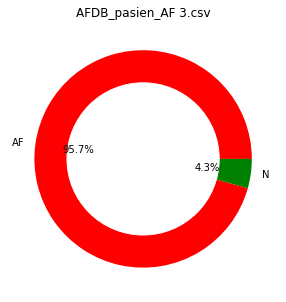


[INFO] Feature (AFDB_pasien_AF 3.csv) :  rr_interval,qt_interval,qrs_complex


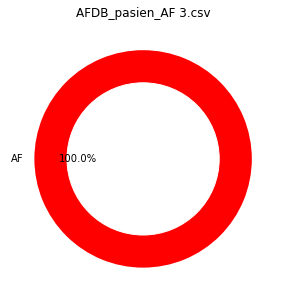




[INFO] Plot for sample :  AFDB_pasien_AF 4.csv

[INFO] Feature (AFDB_pasien_AF 4.csv) :  rr_interval


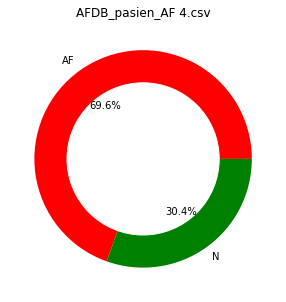


[INFO] Feature (AFDB_pasien_AF 4.csv) :  qt_interval


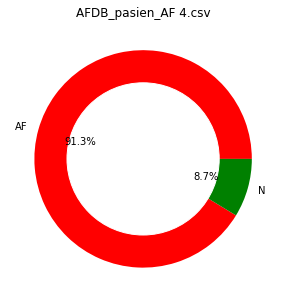


[INFO] Feature (AFDB_pasien_AF 4.csv) :  qrs_complex


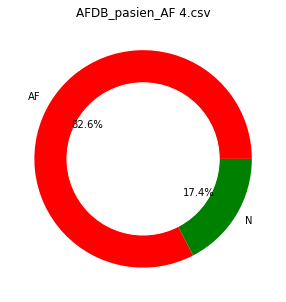


[INFO] Feature (AFDB_pasien_AF 4.csv) :  rr_interval,qt_interval


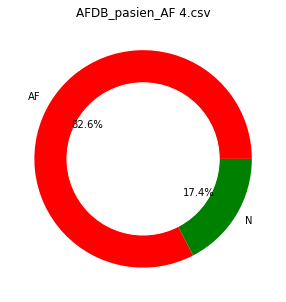


[INFO] Feature (AFDB_pasien_AF 4.csv) :  rr_interval,qrs_complex


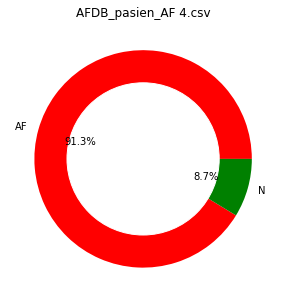


[INFO] Feature (AFDB_pasien_AF 4.csv) :  qt_interval,qrs_complex


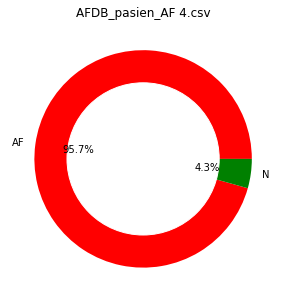


[INFO] Feature (AFDB_pasien_AF 4.csv) :  rr_interval,qt_interval,qrs_complex


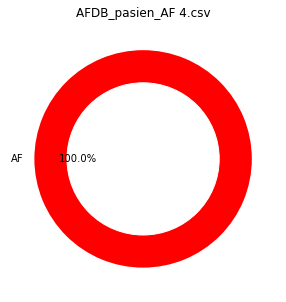




[INFO] Plot for sample :  AFDB_pasien_AF 5.csv

[INFO] Feature (AFDB_pasien_AF 5.csv) :  rr_interval


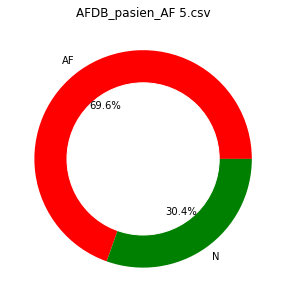


[INFO] Feature (AFDB_pasien_AF 5.csv) :  qt_interval


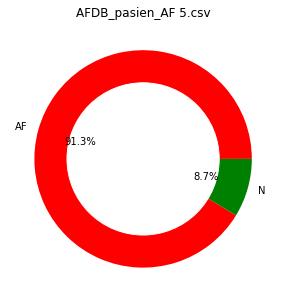


[INFO] Feature (AFDB_pasien_AF 5.csv) :  qrs_complex


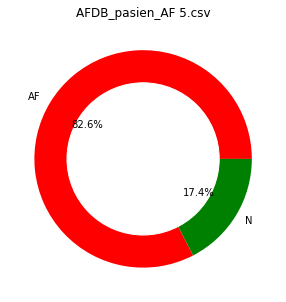


[INFO] Feature (AFDB_pasien_AF 5.csv) :  rr_interval,qt_interval


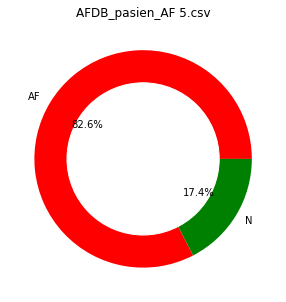


[INFO] Feature (AFDB_pasien_AF 5.csv) :  rr_interval,qrs_complex


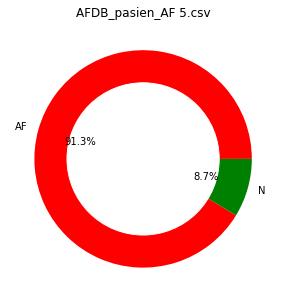


[INFO] Feature (AFDB_pasien_AF 5.csv) :  qt_interval,qrs_complex


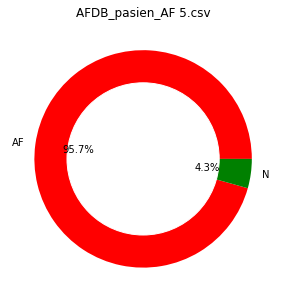


[INFO] Feature (AFDB_pasien_AF 5.csv) :  rr_interval,qt_interval,qrs_complex


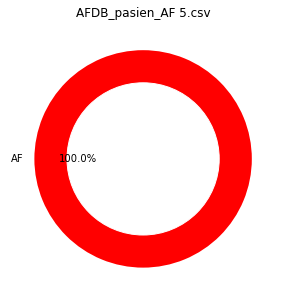




[INFO] Plot for sample :  AFDB_pasien_AF 6.csv

[INFO] Feature (AFDB_pasien_AF 6.csv) :  rr_interval


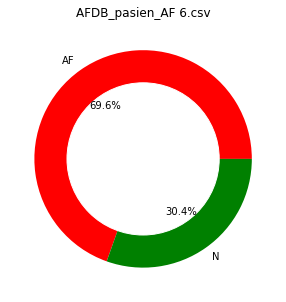


[INFO] Feature (AFDB_pasien_AF 6.csv) :  qt_interval


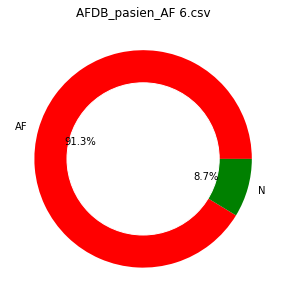


[INFO] Feature (AFDB_pasien_AF 6.csv) :  qrs_complex


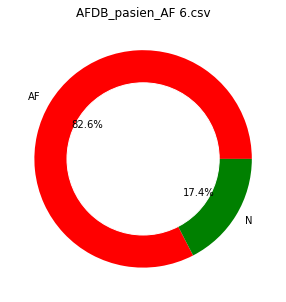


[INFO] Feature (AFDB_pasien_AF 6.csv) :  rr_interval,qt_interval


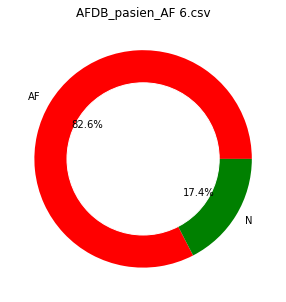


[INFO] Feature (AFDB_pasien_AF 6.csv) :  rr_interval,qrs_complex


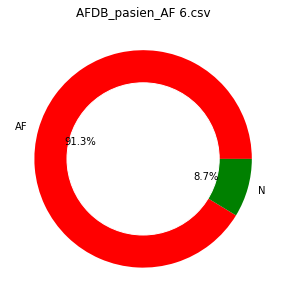


[INFO] Feature (AFDB_pasien_AF 6.csv) :  qt_interval,qrs_complex


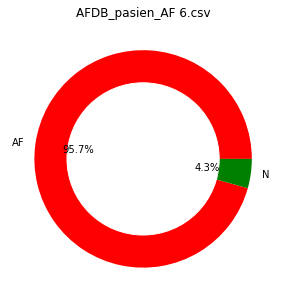


[INFO] Feature (AFDB_pasien_AF 6.csv) :  rr_interval,qt_interval,qrs_complex


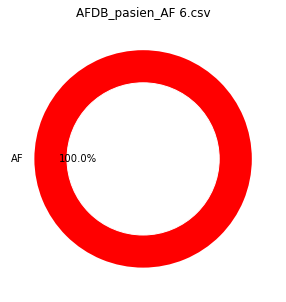




[INFO] Plot for sample :  AFDB_pasien_AF 7.csv

[INFO] Feature (AFDB_pasien_AF 7.csv) :  rr_interval


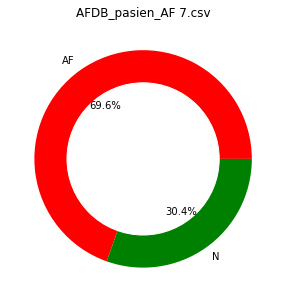


[INFO] Feature (AFDB_pasien_AF 7.csv) :  qt_interval


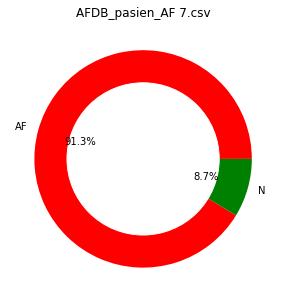


[INFO] Feature (AFDB_pasien_AF 7.csv) :  qrs_complex


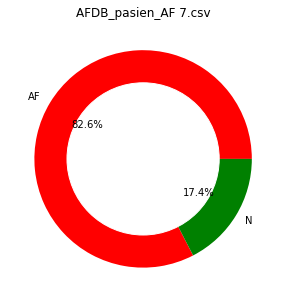


[INFO] Feature (AFDB_pasien_AF 7.csv) :  rr_interval,qt_interval


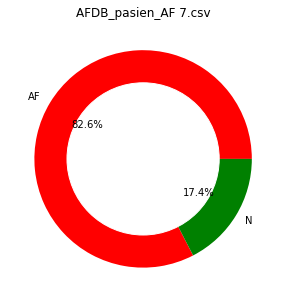


[INFO] Feature (AFDB_pasien_AF 7.csv) :  rr_interval,qrs_complex


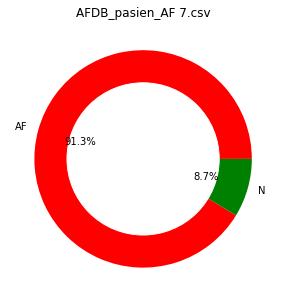


[INFO] Feature (AFDB_pasien_AF 7.csv) :  qt_interval,qrs_complex


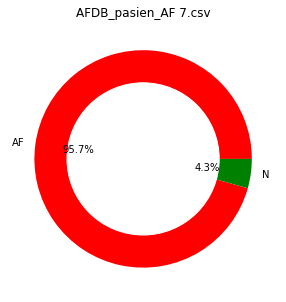


[INFO] Feature (AFDB_pasien_AF 7.csv) :  rr_interval,qt_interval,qrs_complex


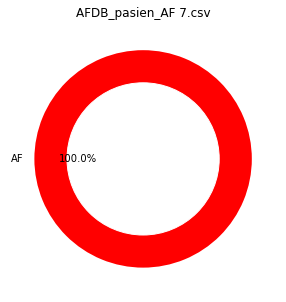




[INFO] Plot for sample :  AFDB_pasien_Normal 1.csv

[INFO] Feature (AFDB_pasien_Normal 1.csv) :  rr_interval


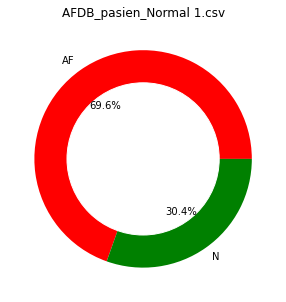


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  qt_interval


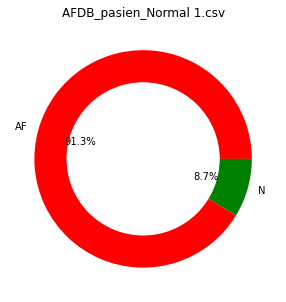


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  qrs_complex


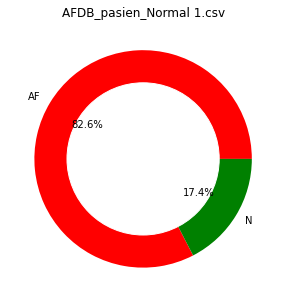


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  rr_interval,qt_interval


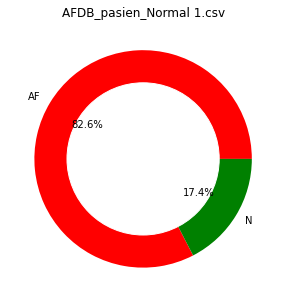


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  rr_interval,qrs_complex


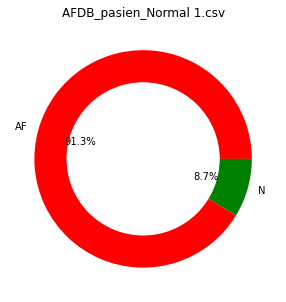


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  qt_interval,qrs_complex


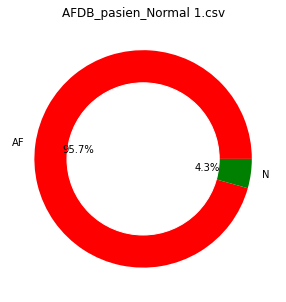


[INFO] Feature (AFDB_pasien_Normal 1.csv) :  rr_interval,qt_interval,qrs_complex


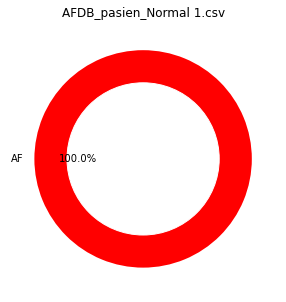




[INFO] Plot for sample :  AFDB_pasien_Normal 2.csv

[INFO] Feature (AFDB_pasien_Normal 2.csv) :  rr_interval


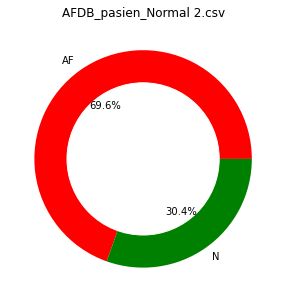


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  qt_interval


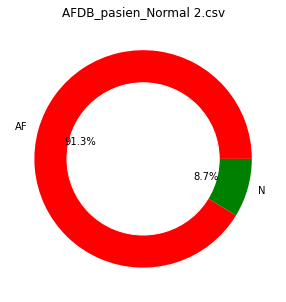


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  qrs_complex


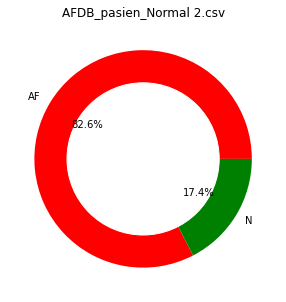


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  rr_interval,qt_interval


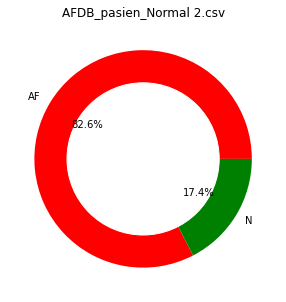


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  rr_interval,qrs_complex


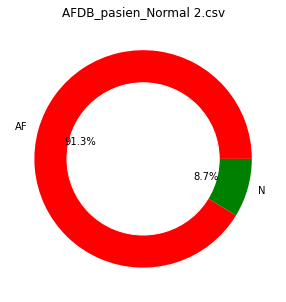


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  qt_interval,qrs_complex


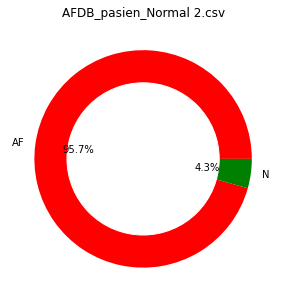


[INFO] Feature (AFDB_pasien_Normal 2.csv) :  rr_interval,qt_interval,qrs_complex


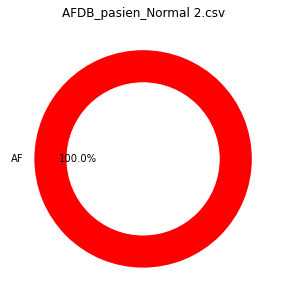




[INFO] Plot for sample :  AFDB_pasien_Normal 3.csv

[INFO] Feature (AFDB_pasien_Normal 3.csv) :  rr_interval


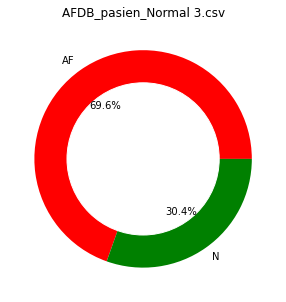


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  qt_interval


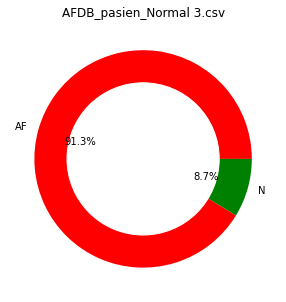


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  qrs_complex


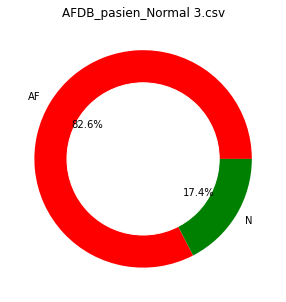


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  rr_interval,qt_interval


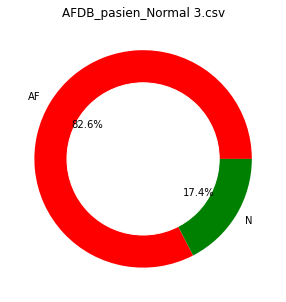


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  rr_interval,qrs_complex


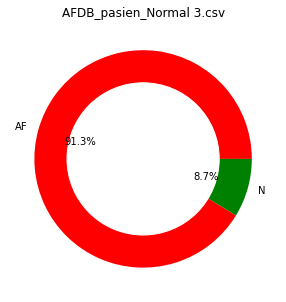


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  qt_interval,qrs_complex


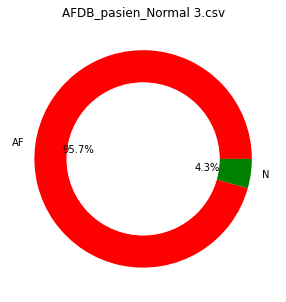


[INFO] Feature (AFDB_pasien_Normal 3.csv) :  rr_interval,qt_interval,qrs_complex


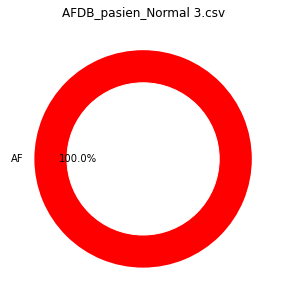




[INFO] Plot for sample :  AFDB_pasien_Normal 4.csv

[INFO] Feature (AFDB_pasien_Normal 4.csv) :  rr_interval


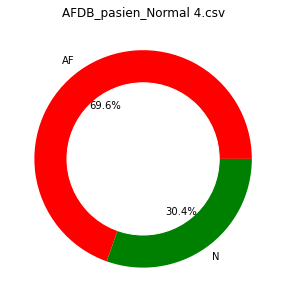


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  qt_interval


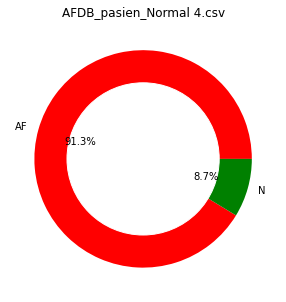


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  qrs_complex


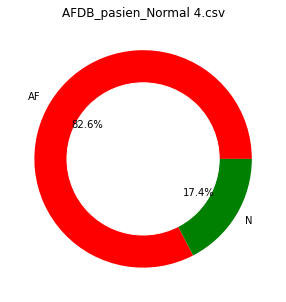


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  rr_interval,qt_interval


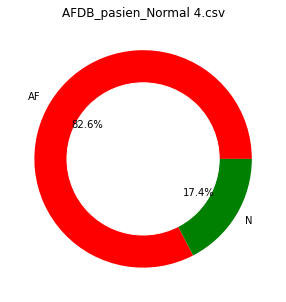


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  rr_interval,qrs_complex


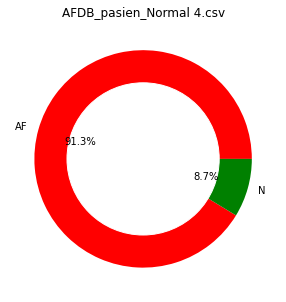


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  qt_interval,qrs_complex


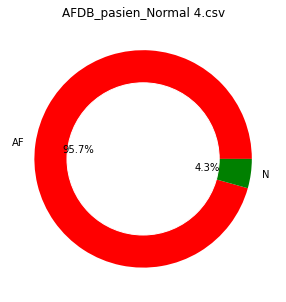


[INFO] Feature (AFDB_pasien_Normal 4.csv) :  rr_interval,qt_interval,qrs_complex


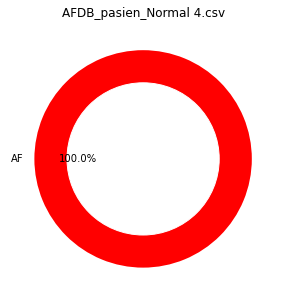

In [54]:
for name in filenames:
    print("\n\n\n[INFO] Plot for sample : ", name)
    for label in feature_labels :
        print("\n[INFO] Feature (%s) : " % name, label)
        pred_result_df = prediction_final_result_df[name][label]
        
        count = dict(pred_result_df[pred_result_df['filename'] == name]['label'].value_counts())
        plot_donat(count.values(), name, count.keys())

- save result as csv

In [55]:
for name in filenames:
    print("\n\n\n[INFO] Save for sample : ", name)
    for label in feature_labels :
        pred_result_df = prediction_final_result_df[name][label]
        pred_result_df.to_csv(dataset_folder + 'inference_result_%s_pasien_%s.csv' % (label, name))
        print("\n[INFO] Saved to : " , dataset_folder + 'inference_result_%s_pasien_%s.csv' % (label, name))




[INFO] Save for sample :  AFDB_pasien_AF 1.csv

[INFO] Saved to :  dataset/inference_result_rr_interval_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_qt_interval_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_qrs_complex_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_rr_interval,qt_interval_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_rr_interval,qrs_complex_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_qt_interval,qrs_complex_pasien_AFDB_pasien_AF 1.csv.csv

[INFO] Saved to :  dataset/inference_result_rr_interval,qt_interval,qrs_complex_pasien_AFDB_pasien_AF 1.csv.csv



[INFO] Save for sample :  AFDB_pasien_AF 2.csv

[INFO] Saved to :  dataset/inference_result_rr_interval_pasien_AFDB_pasien_AF 2.csv.csv

[INFO] Saved to :  dataset/inference_result_qt_interval_pasien_AFDB_pasien_AF 2.csv.csv

[INFO] Saved to :  dataset/inference_r